# Introducción a QAOA 

En este notebook demostramos como resolver un problema de tipo QUBO, en concreto Minimum Vertex Cover, utilizando OpenQAOA.

La información sobre como instalar, utilizar y contribuir a OpenQAOA se encuentra en https://openqaoa.entropicalabs.com/

El código se encuentra en GitHub: https://github.com/entropicalabs/openqaoa/tree/main

Todo lo detallado aquí (y más!) se puede encontrar en los tutoriales de OpenQAOA: https://github.com/entropicalabs/openqaoa/tree/main/examples

In [1]:
#pip install openqaoa

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

### Definición del problema

El Minimum Vertex Cover consiste en, dado un grafo, encontrar el conjunto de vertices mas pequeños tal que cada arista sea incidente en al menos un vertice del conjunto. Su función de coste es:

\begin{equation}
C(x) = B \sum_{i} x_{i} + A \sum_{(i,j) \in E} (1-x_{i})(1-x_{j})
\end{equation}

donde $A$ y $B$ son parametros de libre eleccion, $E$ es el conjunto de aristas del grafo y $x_{i} \in \{0,1\}$ son variables binarias, en las que $x_{i} = 1$ significa que el vertice $i$ esta dentro del cover y $x_{i} = 0$ qwue esta fuera. 

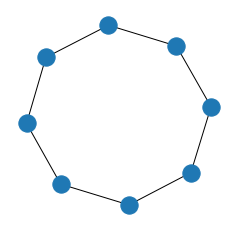

In [3]:
# Numero de variables
N = 8

G = nx.circulant_graph(N,[1])

fig, ax = plt.subplots(1,1,figsize=(4, 4))
nx.draw(G)

Utilizando este grafo podemos definir una instancia del problema MVC

In [4]:
# Del folder "problems" extraemos la clase MVC (hay muchas mas dentro!)
from openqaoa.problems import MinimumVertexCover

# Parametros de MVC
B = 1
A = 10

# Definimos MVC y extraemos el QUBO
mvc = MinimumVertexCover(G,field = B,penalty = A).qubo

Para futura referencia utilizamos la funcion 'ground_state_hamiltonian' la cual extrae el estado y energia fundamentales de un Hamiltoniano

In [5]:
from openqaoa.utilities import ground_state_hamiltonian

# Extraemos el Hamiltoniano de coste

hamiltoniano = mvc.hamiltonian

# Obtenemos sus propiedades
energia, solucion = ground_state_hamiltonian(hamiltoniano)
print(f"Energia Minima: {energia}, Solucion: {solucion}")

Energia Minima: 4.0, Solucion: ['10101010', '01010101']


Aunque aqui hemos utilizado un clase predefinida, es tambien posible definir un QUBO o un Hamiltoniano de coste manualmente, lo que nos permite diseñar cualquier problema para resolver con QAOA.

### Definición de nuestro QAOA ansatz

In [6]:
from openqaoa import QAOA

# Instancia de QAOA
q = QAOA()

Definimos las propiedades del circuito que implementa el QAOA Ansatz

In [7]:
# Numero de capas
p = 1

# Tipo de parametrizacion (standard, fourier, extended, etc.)
parametrizacion = 'standard'

# Tipo de Hamiltoniano de mezcla (pueden ser especificados manualmente!)
mix = 'x'

# Tipo de inicializacion de los parametros variacionales (aleatoria o predefinida)
inicializacion = 'ramp'


# Especificamos estas propiedas del circuito en nuestro QAOA
q.set_circuit_properties(p = p, param_type = parametrizacion, mixer_hamiltonian = mix, init_type = inicializacion)

Definimos las propiedades de nuestro optimizador clasico

In [8]:
# Metodo de optimizacion (incluye todos los de scipy!)
optimizador = 'COBYLA'

# Numero maximo de iteraciones
maxiter = 200

# Tolerancia del optimizador
tol = 0.001

# Especificamos las propiedades de la optimizacion clasica - incluimos que se guarde la evolucion de los parametros y del valor esperado el Hamiltoniano de coste
q.set_classical_optimizer(method=optimizador, maxiter=maxiter, tol=tol, cost_progress=True, parameter_log=True)

Antes de ejecutar nada, tenemos que especificar en que dispositivo queremos resolver este problema! Una computadora cuantica? Un simulador de Qiskit?...La ventaja de OpenQAOA es su capacidad de implementar QAOA en una gran variedad de proveedores (IBM, Rigetti, AWS, Azure, y tambien tiene su propio simulador, 'vectorized'). Aquí, como ejemplo, elegimos el shot simulator de Qiskit.

In [9]:
# Para especificar un dispsotivo importamos la funcion
from openqaoa.backends import create_device

# Definimos el shot simulator como dispositivo
qiskit_shot = create_device(location='local', name='qiskit.shot_simulator')

# Especificamos el dispositivo en nuestra instancia de QAOA
q.set_device(qiskit_shot)

# Propiedades
n_shots = 1000

q.set_backend_properties(n_shots = n_shots)

Podemos chequear cuales son los dispositivos disponibles simplemente ejecutando:

In [10]:
print(f'Los dispositivos disponibles de manera local son {q.local_simulators}\n')
print(f'Los dispositivos disponibles en remoto son {q.cloud_provider}')

Los dispositivos disponibles de manera local son ['qiskit.qasm_simulator', 'qiskit.shot_simulator', 'qiskit.statevector_simulator', 'vectorized', 'pyquil.statevector_simulator', 'analytical_simulator']

Los dispositivos disponibles en remoto son [<class 'openqaoa_qiskit.backends.devices.DeviceQiskit'>, <class 'openqaoa_pyquil.backends.devices.DevicePyquil'>, <class 'openqaoa_braket.backends.devices.DeviceAWS'>, <class 'openqaoa_azure.backends.devices.DeviceAzure'>]


Ya tenemos todos los ingredientes necesarios para ejecutar QAOA! Antes de seguir, es necesario compilar nuestra instancia, lo cual nos permite chequear que todas las propiedades que hemos especificado son validas y podemos proceder a la ejecucion. En este paso es donde especificamos el problema QUBO que queremos resolver!

In [11]:
q.compile(mvc)

### Ejecucion de QAOA

In [12]:
q.optimize()

Asi de simple! Ahora veamos cual es el resultado que hemos obtenido

In [13]:
# Extraemos el resultado
result = q.result

In [14]:
# Resultado mas probable
print(f' El resultado mas probable es {result.most_probable_states}')

 El resultado mas probable es {'solutions_bitstrings': ['10101010'], 'bitstring_energy': 4.0}


states kept: 20


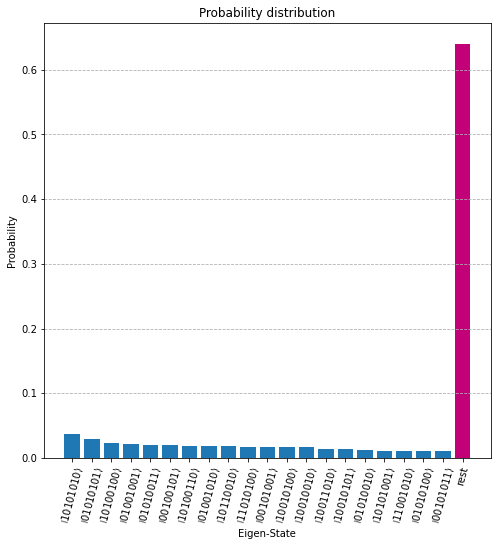

In [15]:
result.plot_probabilities(figsize = (8,8),n_states_to_keep = 20)

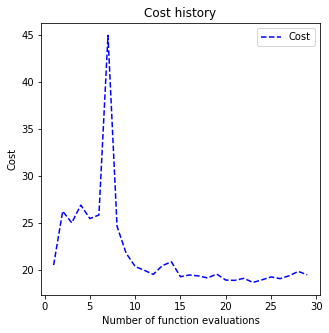

In [16]:
# Evolucion de del valor esperado del Hamiltoniano de coste - Aqui la etiqueta "cost" se refiere a <H>
result.plot_cost(figsize=(5,5))

## A experimentar!

Prueba cambiar cualquier otro parametro y observa como cambia el resultado

Energia Minima: 8.0, Solucion: ['10110100101110']


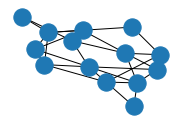

In [17]:
N = 14
# G = nx.complete_graph(N)
# G = nx.circulant_graph(N,[1])
# G = nx.random_regular_graph(d = 3, n = N, seed = 42)
G = nx.erdos_renyi_graph(n = N, p = 0.25, seed = 42)

mvc = MinimumVertexCover(G,field = 1,penalty = 10).qubo
hamiltoniano = mvc.hamiltonian

energia, solucion = ground_state_hamiltonian(hamiltoniano)
print(f"Energia Minima: {energia}, Solucion: {solucion}")

fig, ax = plt.subplots(1,1,figsize=(3, 2))
nx.draw(G)

In [18]:
# Creamos un QAOA
q = QAOA()

# Propiedades del circuito
q.set_circuit_properties(p = 10, param_type = 'standard', mixer_hamiltonian = 'x', init_type = 'ramp')

# Propiedades del optimizador
q.set_classical_optimizer(method='cobyla', maxiter=200, tol=0.001, cost_progress=True, parameter_log=True)

# Propiedades del dispositivo
oq_vectorized = create_device(location='local', name='vectorized')
q.set_device(oq_vectorized)


q.compile(mvc)
q.optimize()

result = q.result
resultado_mas_probable = result.most_probable_states
estados_mas_probables = resultado_mas_probable['solutions_bitstrings']
energia_mas_probable = resultado_mas_probable['bitstring_energy']

 El resultado mas probable es {'solutions_bitstrings': ['10110100101110'], 'bitstring_energy': 8.0}

states kept: 10


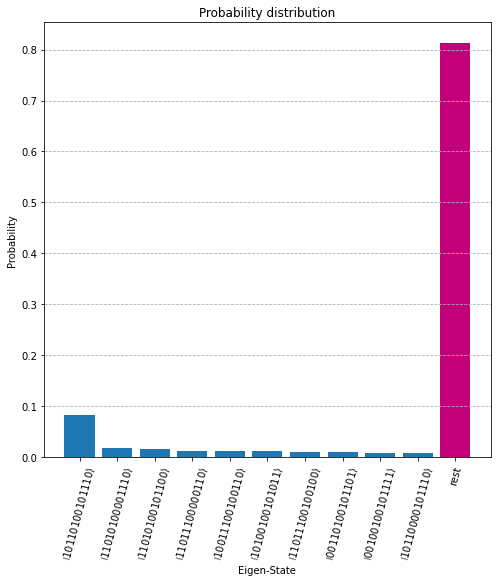

In [19]:
print(f' El resultado mas probable es {result.most_probable_states}\n')

result.plot_probabilities(figsize = (8,8),n_states_to_keep = 10)

## Ideas para seguir explorando

(La clave es nunca dejar de hacerse preguntas y no temer en explorar a fondo lo que nos pique la curiosidad!)

### El ansatz
* Que pasa cuando incremento el numero de capas?
* Diferentes parametrizaciones: 'fourier', 'extended' - En que se diferencian de la estandard?

### El proceso de optimizacion
* Que resultados obtengo comparando distintos metodos de optimizacion? Por ejemplo, COBYLA, Nelder-Mead, Gradient Descent
* Que impacto tiene cambiar el numero de pasos y la tolerancia?

### Dispositivos

* Como se compara el performance de los shot simulators vs state vector simulators?
* Como puedo incluir un modelo de ruido? (Pista: buscar en los tutoriales de OpenQAOA)
* Acceder a uno de los dispositivos de Open Plan de IBM y ejecutar QAOA

### Variantes

Otro de los aspectos interesantes de OpenQAOA es que esta implementada la variante Recursive QAOA, en el tutorial numero 9 puedes encontrar un resumen sobre esta tecnica y como resolver problemas QUBO al igual que en este tutorial.

* Cuales son las principales diferencias entre QAOA y RQAOA? Especialmente, en que se diferencian los outputs de cada algoritmo?
* Cual de los dos es mas eficiente?
* Cual devuelve el mejor resultado?


### Desafios y contribucion

En la web de OpenQAOA encontraras mas ideas con las que seguir aprendiendo y, ademas, ciertos puntos en los que puedes empezar a contribuir

* Implementar otras variantes de QAOA (por ejemplo, ADAPT-QAOA)
* Añadir nuevos metodos para procesar el resultado
* Hacer OpenQAOA compatible con Qiskit Runtime
* Mucho mas en https://openqaoa.entropicalabs.com/challenges/intro/